# Theory Approving Experiment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import numpy as np
from tqdm.auto import tqdm

from src.models import MLP
from src.models import train
from src.utils import init_dataloader
from src.utils import sliding_avg
from src.eigenvalues import HessianEigenvector
from src.models import get_loss
from src.models import hessian_theoretical
from src.visualize import DeltaVisualizer
from src.visualize import vis_compare
from src.calc import DeltaCalculator
from src.directions import EigenDirection

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = init_dataloader(
    dataset_name='MNIST',
    transform=transform,
    batch_size=64,
    dataset_load_path='data/',
    train_mode=True,
    size=64 * (10000 // 64)
)

test_loader = init_dataloader(
    dataset_name='MNIST',
    transform=transform,
    batch_size=64,
    dataset_load_path='data/',
    train_mode=False,
    size=64 * (10000 // 64)
)

In [3]:
model = MLP(layers_num=2, hidden=256, input_channels=1, input_sizes=(28, 28), classes=10).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(model, criterion, train_loader, optimizer, num_epochs=10)

loss = get_loss(model, criterion, train_loader, device=DEVICE)
func = torch.cumsum(loss, dim=0) / torch.arange(1, loss.size(0) + 1, device=model.device)

In [4]:
eigen = []
for i in tqdm(range(len(func))):
    eigen.append(HessianEigenvector(model.parameters(), func[i]).get(10)[0])
eigen = np.array(eigen)

  0%|          | 0/156 [00:00<?, ?it/s]

In [5]:
core_e = EigenDirection(model, criterion, train_loader)
calc_e = DeltaCalculator(model, criterion, train_loader, core_e)
vis_e = DeltaVisualizer(calc_e)

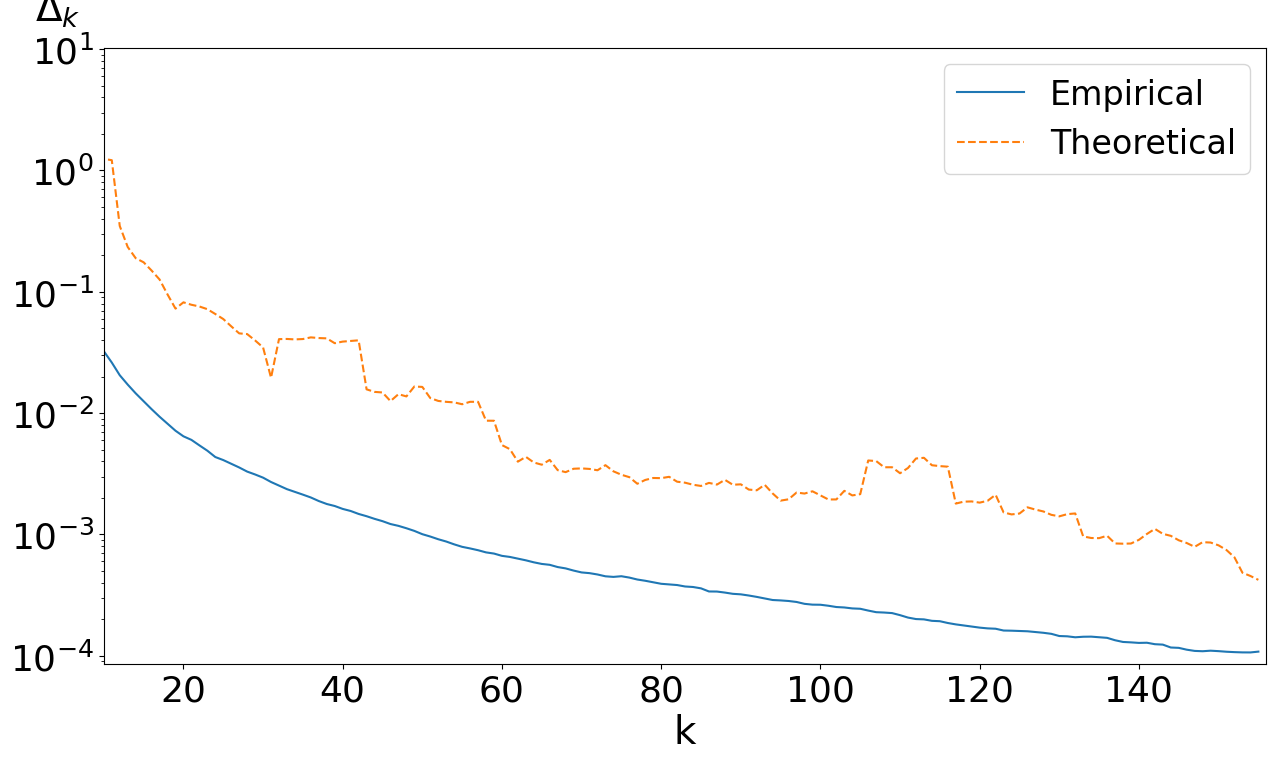

In [6]:
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['legend.fontsize'] = 24

theory = sliding_avg(hessian_theoretical(eigen), 5)

params = {'dim': 10, 'sigma': 1}
num_samples = 1024
deltas = vis_e.visualize_border(theory,
                                params=params,
                                num_samples=num_samples,
                                begin=10, striding_func=lambda x: sliding_avg(x, 5), return_deltas=True)

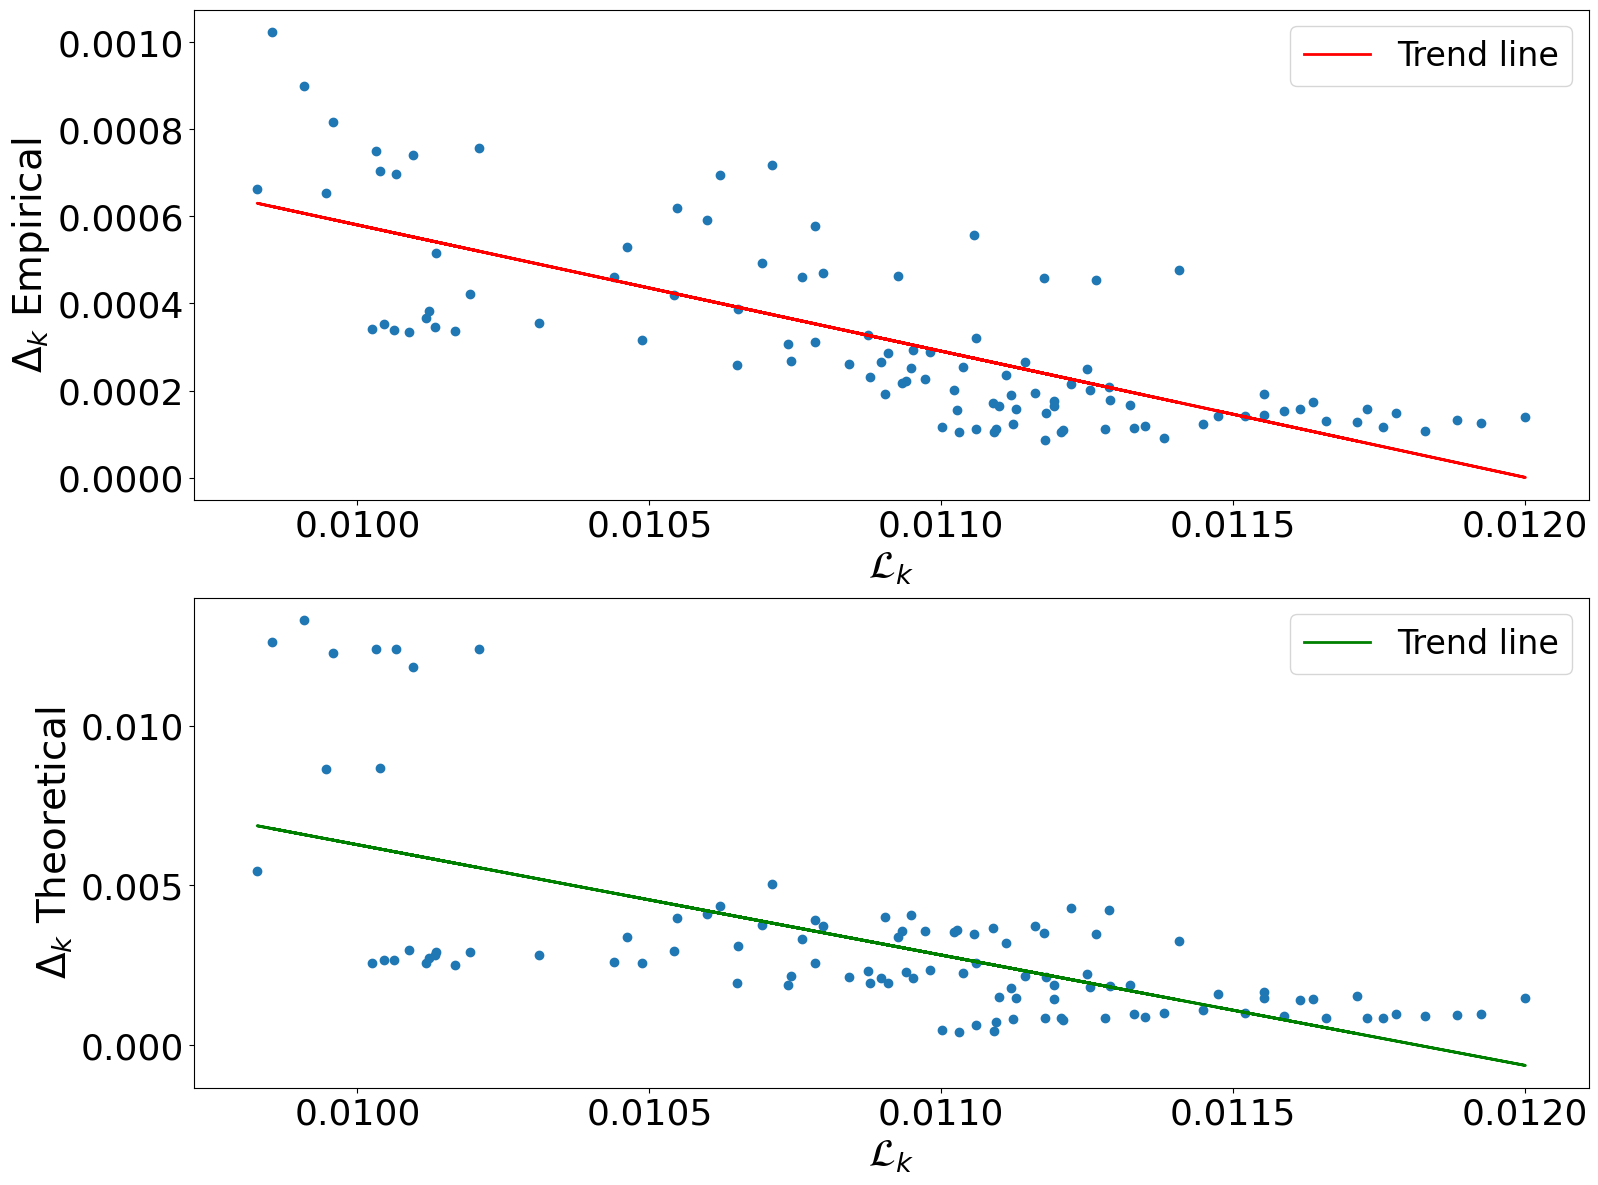

In [19]:
vis_compare(theory, deltas, func, params, num_samples, begin=50)